# Определение закономерностей, определяющих успешность игры

#### Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы долларов)
* EU_sales — продажи в Европе (миллионы долларов)
* JP_sales — продажи в Японии (миллионы долларов)
* Other_sales — продажи в других странах (миллионы долларов)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

#### Цель работы: 
выявить определяющие успешность игры закономерности для планирования рекламных компаний.

#### План работы:  
1. [Общая информация по файлу с данными.](#step1) 
2. [Предобработка данных.](#step2) 
3. [Исследовательский анализ данных.](#step3) 
4. [Составим портрет пользователя каждого региона.](#step4) 
5. [Общий вывод.](#step5) 

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy import stats as st

In [5]:
import seaborn as sns

### Шаг 1. Откроем файлы с данными и изучим общую информацию<a id="step1">

In [6]:
games = pd.read_csv('games.csv')

In [7]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [9]:
#посмотрим значения в столбце Rating
games['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

### Вывод

Файл с данными содержит 11 столбцов и 16715 строк. Столбец Year_of_Release содержит 267 пропущенных значений и имее тип float вместо datetime, так как в нем содержатся даты, возможно точная дата релиза не известна, таких значений около 1,5%, их можно заменить на константу или удалить, так как для восстановления информации недостаточно. Столбец Critic_Score содержит 8578 пустых значений, столбец User_Score 6701 пустых значений и тип object, а более подходящий int или float, т.к. там находятся значение оценок в баллах, возможно, не все игры подвергались оценке. Столбец Rating содержит 6766 пропущенных значений, скорее всего это не случайные пропуски, тк их много, а халатность при заполнении данных. Названия столбцов записаны в разных регистрах, необходимо привести их к нижнему.  

В столбце Rating присутствуют значения E, M, T, E10+, K-A, AO, EC, RP. Это рейтинг ESRB (Entertainment Software Rating Board)  ассоциации, определяющей возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, которой игра будет интересна. E и K-A - для всех, M - для взрослых (17+), T - подросткам (13+), E10+ - для всех от 10 и старше, AO - только для взрослых (18+), EC - для детей младшего возраста (3+), RP - рейтинг ожидается (до даты выпуска игры в продажу).

### Шаг 2. Предобработка данных.<a id="step2">

In [10]:
#приведем заголовки к нижнему регистру
games.columns = (games.columns).str.lower()

In [11]:
#приведем столбцы name, platform, genre к нижнему регистру
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()

In [12]:
#в столбце year_of_release указан год дробным числом, мы не будем переводить его в datetime, тк в столбце нет информации и полной 
#дате (месяц, день), а заменим тип float на int
#но перед тем как это сделать нужно заменить пропущенные значения на NaN, а их на 0, иначе при переводе в тип int возникнет ошибка
games['year_of_release'] = pd.to_numeric(games['year_of_release'], errors='coerce')
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype('int')

In [13]:
#рассмотрим данные в столбце user_score
games['user_score'].unique()
print((games['user_score']=='tbd').value_counts())

False    14291
True      2424
Name: user_score, dtype: int64


В столбце rating есть значения E и K-A - для всех, эти абревиатуры имеют одинаковое значение, но на более ранних версиях
использовалось K-A, заменим их на E

In [14]:
games['rating'] = games['rating'].replace('K-A', 'E')
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

В столбце user_score содержится 2424 значений "tbd", так как в столбце должны содержаться числовые значения с оценками,
делаем вывод, что "tbd" это пропущенные значения, заменим их на NaN

In [15]:
#"tbd" заменим на NaN
#изменим тип в столбце user_score на float
games['user_score'] = games['user_score'].replace('tbd', 'NaN')
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


In [16]:
#в столбце с оценками пользователей очень много пустых значений, посмотрим временной интервал пропусков
user_score_nan = games.loc[:, ['year_of_release', 'user_score']]
user_score_nan = user_score_nan.query('user_score == "NaN"')
before_2000 = user_score_nan.query('year_of_release < 2005').count()
after_2000 = user_score_nan.query('year_of_release >= 2005').count()

In [17]:
#в столбце с оценками критиков очень много пустых значений, посмотрим временной интервал пропусков
critic_score_nan = games.loc[:, ['year_of_release', 'critic_score']]
critic_score_nan = critic_score_nan.query('critic_score == "NaN"')
c_before_2000 = critic_score_nan.query('year_of_release < 2005').count()
c_after_2000 = critic_score_nan.query('year_of_release >= 2005').count()

In [18]:
user_score_nan.count(), critic_score_nan.count()

(year_of_release    9125
 user_score            0
 dtype: int64,
 year_of_release    8578
 critic_score          0
 dtype: int64)

In [19]:
score_nan = games.loc[:, ['year_of_release', 'user_score', 'critic_score']]
score_nan = score_nan.query('user_score == "NaN" & critic_score == "NaN"')
score_nan.count()

year_of_release    8005
user_score            0
critic_score          0
dtype: int64

In [20]:
#посчитаем суммарные продажи во всех регионах, запишем их в столбец total_sales
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales']

### Вывод

Регистры текстовых значений в таблице разные, для удобства привели все к нижнему.   
Значения в столбце с годом релиза перевели в целочисленное, а пустые значения изменили на 0, потому что год релиза этих игр не известен, и предположить мы его не можем.  
Значения в столбце с оценками пользователей привели к типу float для возможности проведения расчетов, а пропущенные значения заменили на NaN. Потому что каждая из рассматриваемых игр индивидуальна и мы не можем предложить варианты для замены оценкок пользователей, а данных об этих оценках у нас нет.  
Возможно это связано с тем, не по всем играм собирали оценки, потому что из отсутствующих значений 9125 в оценках пользователей и 8578 в оценках критиков, 8005 отсутствующих оценок совпадают в обоих группах. А вот с датой релиза наличие оценок не связано.
В столбце rating около 40% пропущенных значений, в столбце находятся категориальные значения, а именно возрастная группа, для их восстановления у нас недостаточно информации.

### Шаг 3. Исследовательский анализ данных.<a id="step3">

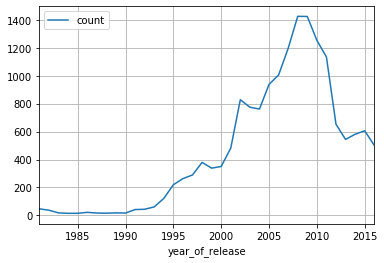

In [21]:
#рассмотрим сколько игр выпускалось в разные годы
sales_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
sales_year.columns = ['year_of_release', 'count']
sales_year.plot(x='year_of_release', y='count', xlim=(1981, 2016), grid=True)
plt.show()

In [22]:
games['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

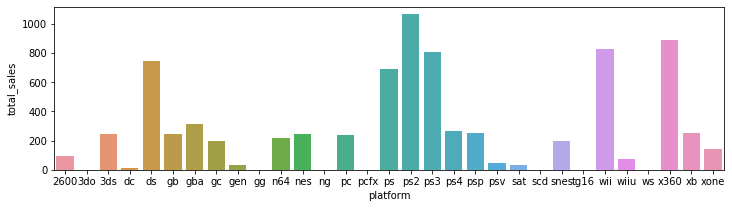

In [23]:
#рассмотрим продажи по платформам
platform_sales = games.pivot_table(index='platform', values='total_sales', aggfunc=['sum']).reset_index()
platform_sales.columns = ['platform', 'total_sales']
plt.figure(figsize=(12, 3))
sns.barplot(x='platform', y='total_sales', data=platform_sales);

Рассмотрим распределение продаж по годам по крупным платформам, будем считать, что это продажи свыше 600 у.е.
Соберем список платформ, подходящих под это условие.

In [24]:
total_sales_platform = platform_sales.query('total_sales >= 600').reset_index()
total_sales_platform = total_sales_platform['platform']
total_sales_platform

0      ds
1      ps
2     ps2
3     ps3
4     wii
5    x360
Name: platform, dtype: object

In [25]:
#отфильтруем таблицу games, оставив только выбранные платформы
games_big = games.query('(platform in @total_sales_platform) and (year_of_release > 0)')
games_big

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,74.09
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,26.92
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,26.07
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,mezase!! tsuri master ds,ds,2009,sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16704,plushees,ds,2008,simulation,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01
16709,score international baja 1000: the official game,ps2,2008,racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [26]:
games_big['platform'].unique()

array(['wii', 'ds', 'x360', 'ps3', 'ps2', 'ps'], dtype=object)

Построим график продаж по выбранным платформам по годам.

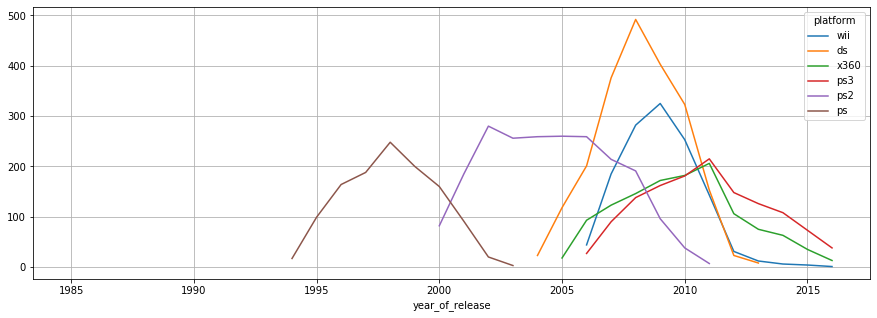

In [27]:
sales_year = games_big.pivot_table(index='year_of_release', columns='platform',
                               values='total_sales', aggfunc='count').reset_index()

sales_year.plot(x='year_of_release', y=['wii', 'ds', 'x360', 'ps3', 'ps2', 'ps'], grid=True, figsize=(15, 5))
plt.show()

По графику выручки от продаж наиболее крупных платформ (6 шт.), видно, что характерный срок появляются новые и исчезают старые платформы составляет не более 10 лет.

In [28]:
#оставим в таблице данные только за вырбанный период 2007-2016 г.г.
games = games.query('year_of_release >= 2007')
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
8,new super mario bros. wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,E,26.08
13,wii fit,wii,2007,sports,8.92,8.03,3.60,2.15,80.0,7.7,E,20.55
14,kinect adventures!,x360,2010,misc,15.00,4.89,0.24,1.69,61.0,6.3,E,20.13


Рассмотрим какие платформы лидируют по продажам в период 2007-2016 г.г.

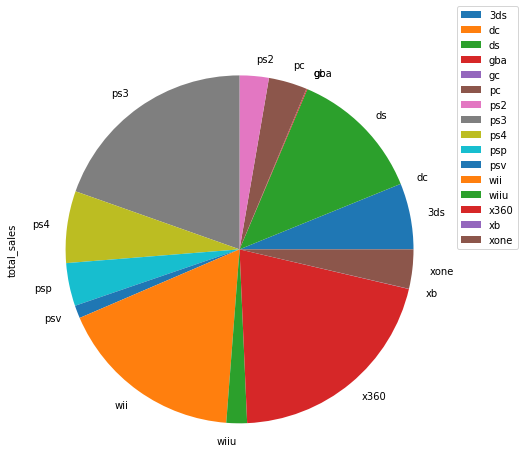

In [29]:
games_sales = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').reset_index()
games_sales.columns = ['platform', 'total_sales']
labels = games_sales['platform']
games_sales.plot.pie(y='total_sales', labels = labels, figsize=(8, 8))
plt.legend(loc=(1, 0.5))
plt.show()

In [30]:
games_sales.sort_values(by='total_sales', ascending=False)

,platform,total_sales
13,x360,821.55
7,ps3,779.45
11,wii,689.84
2,ds,496.83
8,ps4,265.79
0,3ds,244.54
9,psp,159.03
15,xone,145.05
5,pc,142.22
6,ps2,107.92


Рассмотрим динамику продаж по платформам за актуальный период, 
но не будем учитывать последний (2016) год, потому что в описании данных сказано, что за 2016 г. они могут быть неполными,
и для наглядности графика исключим платформы с продажами менее 50 млн.дол.

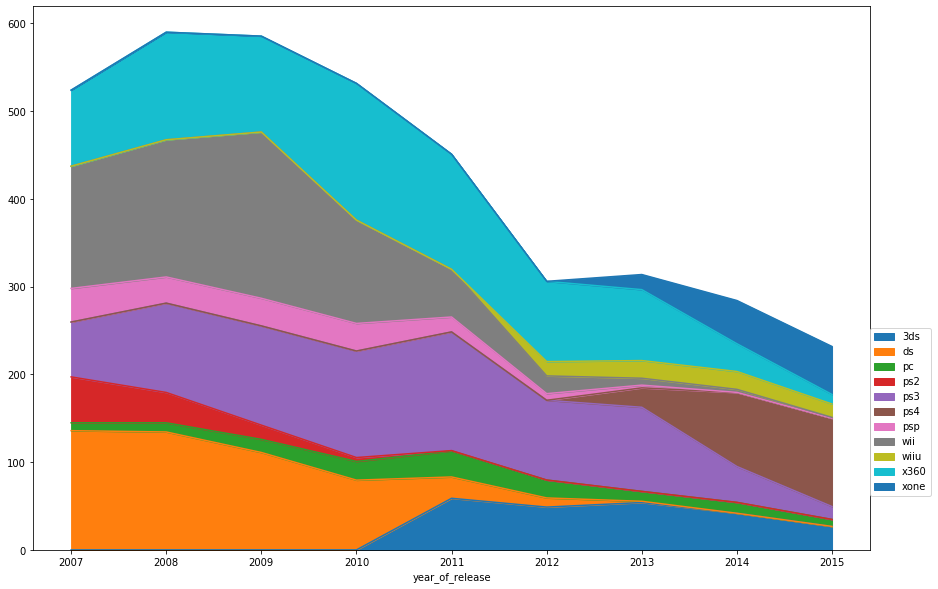

In [31]:
platform_sales = (games
                  .query('(year_of_release <= 2015) and (platform != ("xb", "gba", "gc", "dc", "psv"))')
                  .pivot_table(index=['year_of_release'], 
                                   values='total_sales', columns='platform', aggfunc='sum')
                 )
platform_sales = platform_sales.sort_values(by='year_of_release', ascending=True)

ax = platform_sales.plot.area(figsize=(15, 10))
plt.legend(loc=(1, 0.1))
plt.show()

#### В 2017 году мы можем считать перспективными платформы:
- 3ds;
- ps4;
- wiiu;
- xone.

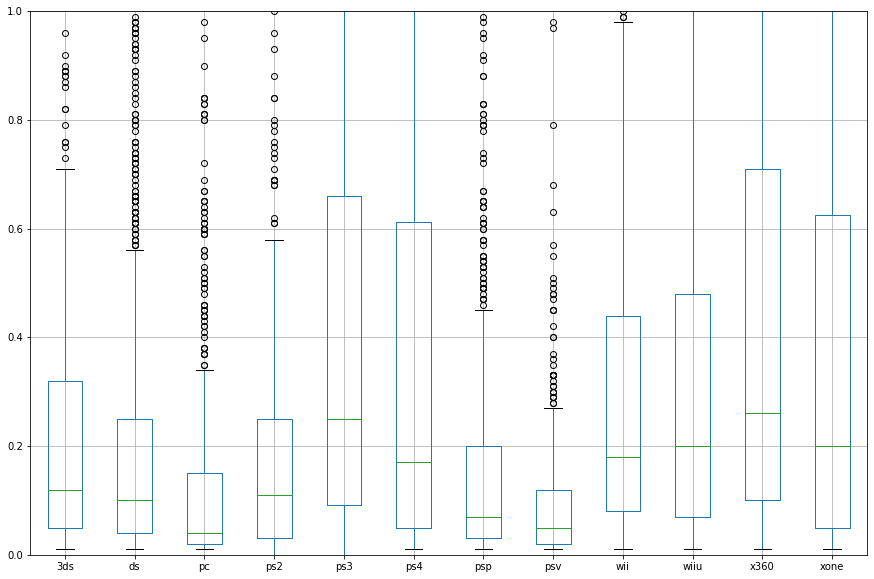

In [32]:
#построим "ящик с усами" по продажам отдельных игр с разбивкой на платформы
platform_sales = (games
                  .query('(platform != ("xb", "gba", "gc", "dc"))')
                  .pivot_table(index='name', 
                                   values='total_sales', columns='platform', aggfunc='sum')
                 )
platform_sales.boxplot(figsize=(15, 10))
plt.ylim(0, 1)
plt.show()


Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков,
в качестве популярной платформы выберем x360, тк на ней самые высокие продажи игр (судя про boxplot).

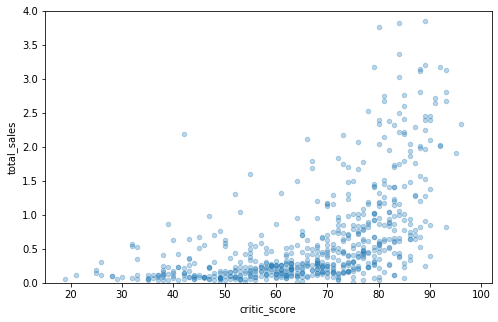

In [33]:
#построим диаграмму рассеяния прожаж и отзыов критиков
sales_score_x360 = (games
               .query('platform == "x360"')
               .pivot_table(index=['platform','critic_score', 'user_score'], values='total_sales').reset_index()
              )
sales_score_x360 = sales_score_x360.sort_values(by='total_sales', ascending=True)
#display(sales_score_x360)
sales_score_x360.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [34]:
#посчитаем корреляцию прожаж и отзывами критиков
print('Корреляция между продажами платформы x360 и отзывами критиков: ', end='')
print(sales_score_x360['critic_score'].corr(sales_score_x360['total_sales']))

Корреляция между продажами платформы x360 и отзывами критиков: 0.4023937467604153


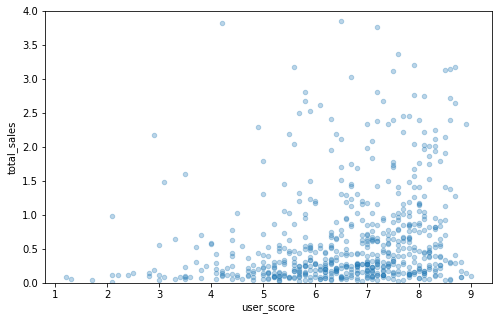

In [35]:
#построим диаграмму рассеяния прожаж и отзывов пользователей
sales_score_x360.plot(x='user_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [36]:
#посчитаем корреляцию прожаж и отзывами пользователей
print('Корреляция между продажами платформы x360 и отзывами пользователей: ', end='')
print(sales_score_x360['user_score'].corr(sales_score_x360['total_sales']))

Корреляция между продажами платформы x360 и отзывами пользователей: 0.10698212650241606


Возможно такая корреляция связана с тем, что недостаточно значений оценок критиков и пользователей на платформе x360. 
Найдем платформы, у которых имеется больше оценок и рассмотрим их.

In [37]:
#удалим значения NaN в оценках, но чтобы не удалить строки навсегда, сделаем для анализа отдельный DF 'platform_score'
platform_score = games.loc[:, ['name', 'platform', 'user_score', 'critic_score']]
platform_score_before = platform_score.pivot_table(
    index=['platform'], values=['user_score', 'critic_score'], aggfunc='count')
platform_score_before.head()

,critic_score,user_score
platform,,
3ds,166,171
dc,0,0
ds,528,361
gba,1,0
gc,3,2


In [38]:
platform_score.dropna(subset = ['user_score', 'critic_score'], inplace=True)

In [39]:
platform_score = platform_score.pivot_table(
    index=['platform'], values=['user_score', 'critic_score'], aggfunc='count')
platform_score.head()

,critic_score,user_score
platform,,
3ds,156,156
ds,326,326
gc,2,2
pc,529,529
ps2,108,108


на платформе ps4 отсутствует всего 1,2% значений и она на данный момент развивается, проверим корреляцию продаж игр с отзывами пользователей по этой платформе

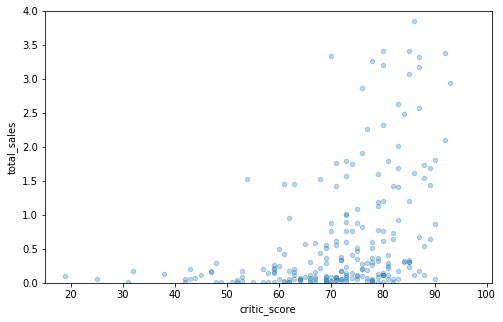

In [40]:
sales_score_ps4 = (games
               .query('platform == "ps4"')
               .pivot_table(index=['platform','critic_score', 'user_score'], values='total_sales').reset_index()
              )
sales_score_ps4 = sales_score_ps4.sort_values(by='total_sales', ascending=True)
#display(sales_score_ps4)
sales_score_ps4.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [41]:
#посчитаем корреляцию прожаж и отзывами критиков
print('Корреляция между продажами платформы ps4 и отзывами критиков: ', end='')
print(sales_score_ps4['critic_score'].corr(sales_score_ps4['total_sales']))

Корреляция между продажами платформы ps4 и отзывами критиков: 0.41184755376964616


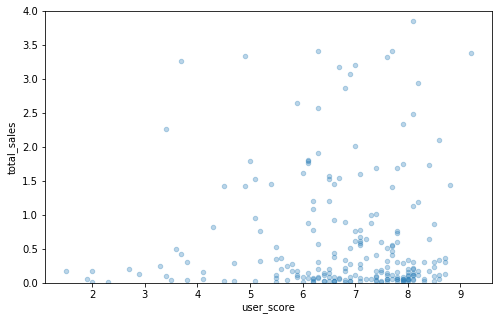

In [42]:
#построим диаграмму рассеяния прожаж и отзывов пользователей
sales_score_ps4.plot(x='user_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [43]:
#посчитаем корреляцию прожаж и отзывами критиков
print('Корреляция между продажами платформы ps4 и отзывами пользователей: ', end='')
print(sales_score_ps4['user_score'].corr(sales_score_ps4['total_sales']))

Корреляция между продажами платформы ps4 и отзывами пользователей: -0.029971316766311457


Рассмотрим зависимость продаж игр с отзывами пользователей по ранее популярной платформе wii, которая уже вышла из типа популярности

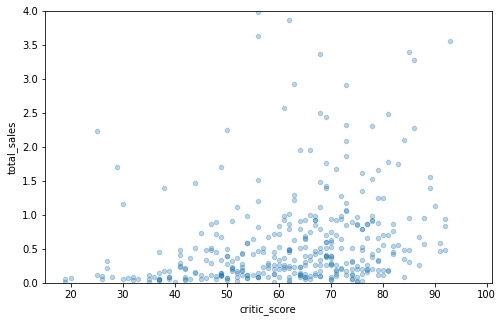

In [44]:
sales_score_wii = (games
               .query('platform == "wii"')
               .pivot_table(index=['platform','critic_score', 'user_score'], values='total_sales').reset_index()
              )
sales_score_wii = sales_score_wii.sort_values(by='total_sales', ascending=True)

sales_score_wii.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [45]:
#посчитаем корреляцию прожаж и отзывами критиков
print('Корреляция между продажами платформы wii и отзывами критиков: ', end='')
print(sales_score_wii['critic_score'].corr(sales_score_wii['total_sales']))

Корреляция между продажами платформы wii и отзывами критиков: 0.24595501263071437


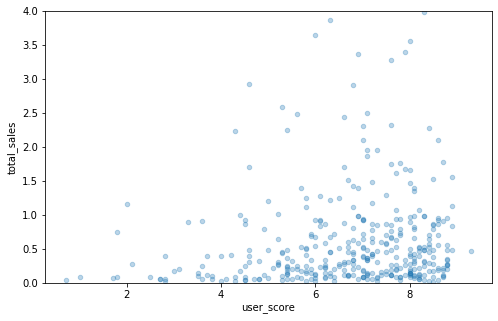

In [46]:
#построим диаграмму рассеяния прожаж и отзывов пользователей
sales_score_wii.plot(x='user_score', y='total_sales', kind='scatter', figsize=(8, 5), alpha=0.3)
plt.ylim(0, 4)
plt.show()

In [47]:
#посчитаем корреляцию прожаж и отзывами критиков
print('Корреляция между продажами платформы wii и отзывами пользователей: ', end='')
print(sales_score_wii['user_score'].corr(sales_score_wii['total_sales']))

Корреляция между продажами платформы wii и отзывами пользователей: 0.15660388743385756


In [48]:
#рассморим корреляцию продаж игр с отзывами пользователей на всех платформах
sales_score = games.pivot_table(index=['platform','critic_score', 'user_score'], values='total_sales').reset_index()
sales_score = sales_score.sort_values(by='total_sales', ascending=True)
print('Корреляция между продажами и отзывами пользователей: ', end='')
print(sales_score['user_score'].corr(sales_score['total_sales']))

Корреляция между продажами и отзывами пользователей: 0.09932086097239236


In [49]:
#рассморим корреляцию продаж игр с отзывами пользователей на всех платформах
print('Корреляция между продажами и отзывами пользователей: ', end='')
print(sales_score['user_score'].corr(sales_score['total_sales']))

Корреляция между продажами и отзывами пользователей: 0.09932086097239236


In [50]:
#рассморим корреляцию продаж игр с отзывами критиков на всех платформах
print('Корреляция между продажами и отзывами критиков: ', end='')
print(sales_score['critic_score'].corr(sales_score['total_sales']))

Корреляция между продажами и отзывами критиков: 0.2883266585662513


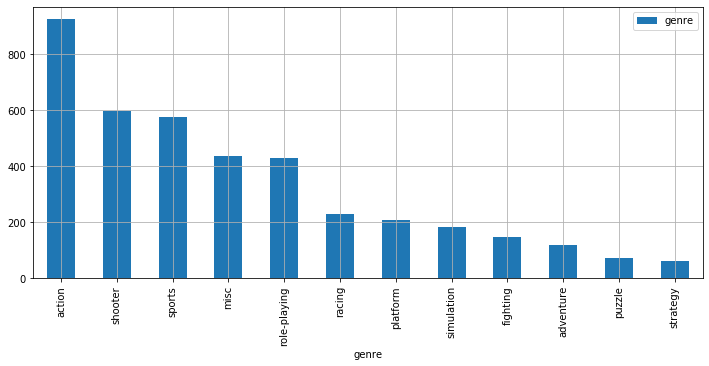

In [51]:
#рассмотрим продажи игр по жанрам
genre_sales = games.pivot_table(index='genre', values='total_sales', aggfunc='sum').reset_index()
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False)
genre_sales.plot(y='total_sales', x='genre', kind='bar', label='genre', figsize=(12, 5), grid=True)
plt.show()

### Вывод

По результатам предобработки данных были сделаны следующие выводы:
- до 2000 года выпускалось очень мало игр, а именно не более 400 игр в год, после 2000 года количество выпущенных игр доходило до 1400 единиц в год, следовательно весь период данных с 1981 года анализировать не рационально;
- только 6 платформ из 31 имеют более значительное количество продаж, а именно более 600 млн.дол., по остальным платформам этот показатель не превышает 250млн.$;
- по графику выручки от продаж наиболее крупных платформ (6 шт.), видно, что характерный срок появляются новые и исчезают старые платформы составляет не более 10 лет;
- на основе вышеперечисленных пунктов примем для анализа и дальнейшего планирования актуальный период равный 10 последних лет, а именно 2007 - 2016 г.г.;
- за последние 10 лет платформы лидеры продаж: x360, wii, ds, 3ds, ps4;
- за последние 10 лет снизились продажи платформ ds, ps3, wii, xone, psp2, x360 а повысились на платформах 3ds, ps4, xone, wiiu; 
- рассмотрели продажи по играм на разных платформах и видим, что на таких платформах, как ps3, ps4, x360, xone, wii, wiiu продажи по играм значительно выше, чем на остальных платформах;
- средние продажи на одну игру саме высокие (более 0,2 млн. дол.)на платформах ps3, wiiu, x360, xone;
- коэффициент корреляции популярной платформы x360 между продажами и оценками игр пользователями и критиками крайне низки (0,1 и 0,4 сответственно), можно сказать, что зависимости нет, но все таки корреляция между продажами и оценками критиков выше, чем между продажами и оценками пользователей. На графиках рассеяния видно, что для отдельных игр такая зависимость прослеживается, но их не много;
- зависимоть продаж от оценок пользователей на развивающейся платформе ps4 также отсутствует;
- зависимоть продаж от оценок пользователей на ранее популярной платформе wii также отсутствует;
- корреляция продаж и отзывов пользователей и критиков по остальным платформам схожа с корреляцией на популярной платформе x360, ps4 и wii;
- продажи игр по жанрам различаются, наиболее прибыльны "активные" и более дорогостоящие игры в жанрах: action, shooter, sports. А менее прибыльны "спокойные" и более дешевые игры в жанрах: adventure, puzzle, strategy.

### Шаг 4. Составим портрет пользователя каждого региона.<a id="step4">

In [52]:
#посчитаем доли продаж по всем патформам в регионе NA за актуальный период
games_NA = games.loc[:, ('name', 'platform', 'year_of_release', 
                        'genre', 'na_sales', 'critic_score', 'user_score', 'rating')]
NA_sales = games_NA.pivot_table(index='platform', values=['na_sales'], aggfunc='sum').reset_index()
NA_total_sum = NA_sales['na_sales'].sum()
NA_sales['share'] = NA_sales['na_sales'] / NA_total_sum
#найдем топ 5 популярных платформ в регионе NA
NA_sales = NA_sales.sort_values(by='share', ascending=False)
NA_sales_top5 = NA_sales.head()
NA_sales_top5

,platform,na_sales,share
13,x360,553.68,0.260612
11,wii,416.01,0.195812
7,ps3,381.29,0.179469
2,ds,273.98,0.128960
8,ps4,108.74,0.051183


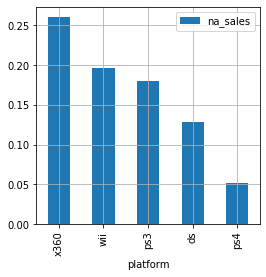

In [53]:
NA_sales_top5.plot(x='platform', y='share', kind='bar', label='na_sales', figsize=(4, 4), grid=True);

In [54]:
#посчитаем доли продаж по всем патформам в регионе EU за актуальный период
games_EU = games.loc[:, ('name', 'platform', 'year_of_release', 
                        'genre', 'eu_sales', 'critic_score', 'user_score', 'rating')]
EU_sales = games_EU.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum').reset_index()
EU_total_sum = EU_sales['eu_sales'].sum()
EU_sales['share'] = EU_sales['eu_sales'] / EU_total_sum
#найдем топ 5 популярных платформ в регионе EU
EU_sales = EU_sales.sort_values(by='share', ascending=False)
EU_sales_top5 = EU_sales.head()
EU_sales_top5

,platform,eu_sales,share
7,ps3,319.83,0.233775
13,x360,257.05,0.187887
11,wii,214.70,0.156932
8,ps4,141.09,0.103128
2,ds,119.92,0.087654


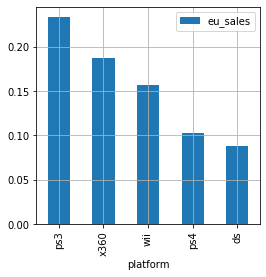

In [55]:
EU_sales_top5.plot(x='platform', y='share', kind='bar', label='eu_sales', figsize=(4, 4), grid=True);

In [56]:
#посчитаем доли продаж по всем патформам в регионе JP за актуальный период
games_JP = games.loc[:, ('name', 'platform', 'year_of_release', 
                        'genre', 'jp_sales', 'critic_score', 'user_score', 'rating')]
JP_sales = games_JP.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum').reset_index()
JP_total_sum = JP_sales['jp_sales'].sum()
JP_sales['share'] = JP_sales['jp_sales'] / JP_total_sum
#найдем топ 5 популярных платформ в регионе JP
JP_sales = JP_sales.sort_values(by='share', ascending=False)
JP_sales_top5 = JP_sales.head()
JP_sales_top5

,platform,jp_sales,share
2,ds,102.93,0.211108
0,3ds,100.62,0.206370
7,ps3,78.33,0.160654
9,psp,66.24,0.135857
11,wii,59.13,0.121275


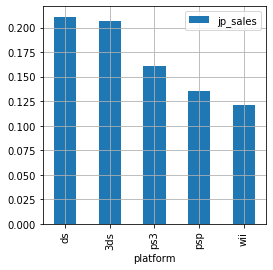

In [57]:
JP_sales_top5.plot(x='platform', y='share', kind='bar', label='jp_sales', figsize=(4, 4), grid=True);

In [58]:
#составим топ 5 популярных жанров в регионе NA
NA_genre = (games_NA
            .pivot_table(index='genre', values='na_sales', aggfunc='sum')
            .sort_values(by='na_sales', ascending=False)
            .head(5)
            .reset_index()
           )
NA_genre

,genre,na_sales
0,action,492.17
1,shooter,350.11
2,sports,323.86
3,misc,259.16
4,role-playing,175.41


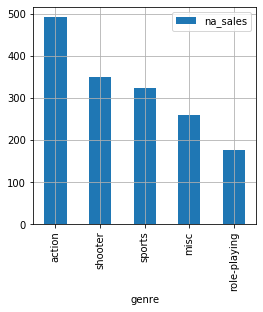

In [59]:
NA_genre.plot(x='genre', y='na_sales', kind='bar', label='na_sales', figsize=(4, 4), grid=True);

In [60]:
#составим топ 5 популярных жанров в регионе EU
EU_genre = (games_EU
            .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
            .sort_values(by='eu_sales', ascending=False)
            .head(5)
            .reset_index()
           )
EU_genre

,genre,eu_sales
0,action,335.67
1,shooter,230.16
2,sports,211.49
3,misc,127.62
4,racing,104.63


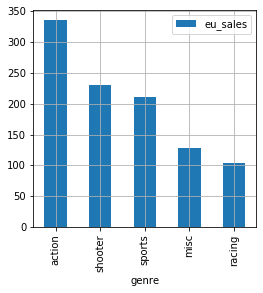

In [61]:
EU_genre.plot(x='genre', y='eu_sales', kind='bar', label='eu_sales', figsize=(4, 4), grid=True);

In [62]:
#составим топ 5 популярных жанров в регионе JP
JP_genre = (games_JP
            .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
            .sort_values(by='jp_sales', ascending=False)
            .head(5)
            .reset_index()
           )
JP_genre

,genre,jp_sales
0,role-playing,150.55
1,action,96.29
2,misc,48.79
3,sports,40.28
4,adventure,26.91


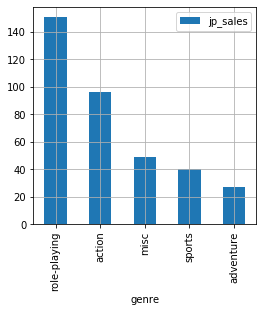

In [63]:
JP_genre.plot(x='genre', y='jp_sales', kind='bar', label='jp_sales', figsize=(4, 4), grid=True);

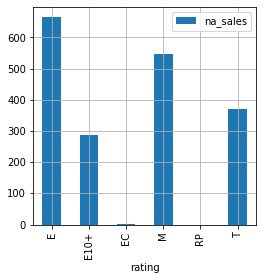

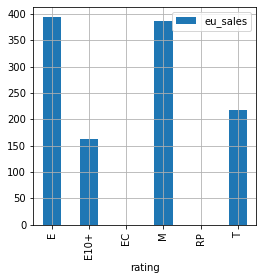

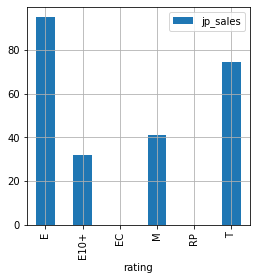

In [64]:
#рассмотрим влияет ли рейтинг ESRB на продажи в регионе
games_NA = games_NA.pivot_table(index='rating', values='na_sales', aggfunc='sum').reset_index()
games_EU = games_EU.pivot_table(index='rating', values='eu_sales', aggfunc='sum').reset_index()
games_JP = games_JP.pivot_table(index='rating', values='jp_sales', aggfunc='sum').reset_index()
games_NA.plot(x='rating', y='na_sales', kind='bar', label='na_sales', figsize=(4, 4), grid=True)
games_EU.plot(x='rating', y='eu_sales', kind='bar', label='eu_sales', figsize=(4, 4), grid=True)
games_JP.plot(x='rating', y='jp_sales', kind='bar', label='jp_sales', figsize=(4, 4), grid=True)
plt.show()

### Вывод

По результатам анализа получили портреты регионов.
1. Популярные платформы:
 - самые популярные платформы в регионе NA: x360, wii, ps3, ds, ps4;
 - самые популярные платформы в регионе EU: ps3, x360, wii, ps4, ds;
 - самые популярные платформы в регионе JP: ds, 3ds, ps3, psp, wii;
 - во всех рассматриваемых регионах в топ 5 по популярности входят платформы: wii, ps3, ds;
 - в регионах NA и EU платформа x360 имеет долю продаж свыше 18%, а в регионе JP она не входит даже в топ 5;
 - в регионе JP самая популярная платформа - ds занимает 23% рынка, при этом в других регионах ее доля не превышает 12%;
 - в регионе NA более выражен отрыв первых четырех позиций от остальных, а именно платформ x360, wii, ps3, ds. Значит популярность остальных платформ там незначительна. В остальных регионах популярность платформ убывает в рейтинге достаточно "плавно";
2. Популярные жанры:  
 - жанры action и sports входят в топ 5 по популярности во всех регионах;
 - в регионах NA и EU одинаково популярны жанры action, shooter, sports и misc;
 - в регионе JP первый по популярности жанр role-playing, при этом он в остальных регионах он не входит в перую четверку по популярности.
3. Рейтинг (целевая аудитория) игры:
 - по анализу продаж видно, что игры с рейтингом E - для возрастной категории от 6 лет и старше, которые также могут понравиться и взрослым имеют самые высокие продажи во всех регионах;
 - игры с рейтингами EC и RP для детей младшего возраста и только для взрослых имеют маленький объем продаж, что логично, так как они охватывают меньше аудитории;
 - в регионе JP на втором месте по популярности рейтинг T - подростки;
 - в регионах NA и EC второй по популярности рейтинг M - для взрослых.

### Шаг 5. Проверка гипотез.<a id="step5">

#### Гипотеза H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
#### Гипотеза H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [65]:
#выведем рейтинги пользователей платформы xone
score_xone = games.loc[:, ['name', 'platform', 'user_score']]
score_xone = score_xone.query('platform == "xone"')
score_xone.head()

,name,platform,user_score
99,call of duty: black ops 3,xone,NaN
165,grand theft auto v,xone,7.9
179,call of duty: advanced warfare,xone,5.4
242,halo 5: guardians,xone,6.4
270,fallout 4,xone,6.2


In [66]:
#выведем рейтинги пользователей платформы pc
score_pc = games.loc[:, ['name', 'platform', 'user_score']]
score_pc = score_pc.query('platform == "pc"')
score_pc.head()

,name,platform,user_score
85,the sims 3,pc,7.6
192,diablo iii,pc,4.0
218,starcraft ii: wings of liberty,pc,8.2
288,world of warcraft: the burning crusade,pc,7.9
313,the elder scrolls v: skyrim,pc,8.1


Примем alpha = 0.05, то есть если с 95% точностью средние пользовательские рейтинги платформ Xbox One и PC одинаковые, то будем считать, что они одинаковые.

In [67]:
#проверим гипотезы, исключив из расчета NaN значения
alpha = .05
results = st.ttest_ind(score_xone['user_score'], score_pc['user_score'], nan_policy='omit')
print('p-значение: ', results.pvalue)

p-значение:  0.05554752084309758


In [68]:
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


С 94,4% точностью принимаем нулевую гипотезу, но результат находится на грани не принятия (более 95%)

#### Гипотеза Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковые
#### Гипотеза Н1: Средние пользовательские рейтинги жанров Action и Sports разные

In [69]:
#выведем рейтинги пользователей по жанру action
score_action = games.loc[:, ['name', 'genre', 'user_score']]
score_action = score_action.query('genre == "action"')
score_action.head()

,name,genre,user_score
16,grand theft auto v,action,8.2
23,grand theft auto v,action,8.1
42,grand theft auto v,action,8.3
46,pokemon heartgold/pokemon soulsilver,action,NaN
51,grand theft auto iv,action,7.9


In [70]:
#выведем рейтинги пользователей по жанру sports
score_sports = games.loc[:, ['name', 'genre', 'user_score']]
score_sports = score_sports.query('genre == "sports"')
score_sports.head()

,name,genre,user_score
3,wii sports resort,sports,8.0
13,wii fit,sports,7.7
15,wii fit plus,sports,7.4
77,fifa 16,sports,4.3
86,mario & sonic at the olympic games,sports,NaN


In [71]:
#проверим гипотезы, исключив из расчета NaN значения
alpha = .05
results = st.ttest_ind(score_action['user_score'], score_sports['user_score'], nan_policy='omit')
print('p-значение: ', results.pvalue)

p-значение:  1.089451491957169e-12


In [72]:
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


### Вывод

Гипотеза 1.  
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Не получилось отвергнуть эту гипотезу, значит рейтинги пользователей на этих платформах скорее одинакавые, чем нет. Для проверки применили метод scipy.stats.ttest_ind , поскольку сравнивали средние значения из двух разных совокупностей. В качестве нулевой гипотезы взяли гипотезу о равенстве, а качестве альтернативной сформировали гипотезу о неравенстве.  
Гипотеза 2.
Средние пользовательские рейтинги жанров Action и Sports разные. Не получилось отвергнуть эту гипотезу. Но мы отвергли противоположную ей (нулевую) гипотезу о том, что Средние пользовательские рейтинги жанров Action и Sports одинаковые. Для проверки применили метод scipy.stats.ttest_ind , поскольку сравнивали средние значения из двух разных совокупностей. В качестве нулевой гипотезы взяли гипотезу о равенстве, а качестве альтернативной сформировали гипотезу о неравенстве.  

### Шаг 6. Общий вывод.<a id="step6">

В ходе аналитической работы были выявлены следующие закономерности, определяющие успешность игры:  
- актуальные и развивающиеся платформы на 2017 год: xone, wiiu, 3ds, ps4;
- самые прибыльные на сегодняшний день платформы: ps3, wiiu, x360, xone, ps4;
- прямой зависимости между оценками критиков и пользователей игр на продажи нет, однако влияние оценок критиков выше, чем пльзователей;
- наиболее прибыльные во всех регионах жанры: action, shooter, sports, более "активные", а также более дорогие;
- наименее прибыльные во всех регионах жанры игр: adventure, puzzle, strategy, наиболее "спокойные", а также более дешевые;
- платформы wii, ps3, ds популярны во всех регионах;
- платформа x360 очень популярна в регионах NA и EU, а в регионе JP не популярна, а платформа psp популярна только в регионе JP;
- жанры action и sports входят в топ 5 по популярности во всех регионах;
- жанр role-playing самый популярный в регионе JP, при этом в остальных регионах он не входит в топ 4 по популярности;
- в регионах NA и EU одинаково популярны жанры: action, shooter, sports и misc;
- по анализу продаж видно, что игры с рейтингом E - для возрастной категории от 6 лет и старше, которые также могут понравиться и взрослым имеют самые высокие продажи во всех регионах;
- игры с рейтингами EC и RP для детей младшего возраста и только для взрослых имеют маленький объем продаж, что логично, так как они охватывают меньше аудитории;
- в регионе JP на втором месте по популярности рейтинг T - подростки;
- в регионах NA и EC второй по популярности рейтинг M - для взрослых;
- самые популярные жанры во всех регионах action и sports имеют разные пользовательские рейтинги;
- пользовательские рейтинги популярной ранее платформы Xbox One и непопулярной за все время анализа платформы PC примерно одинаковые, а значит не оказывают большого влиятия на продажи.

Итоговый вывод. 

Успешная игра скорее всего будет иметь характеристики:
- размещена на платформах x360, 3ds, ps4;
- относится к жанрам action и sports;
- имеет рейтинг целевой аудитории E;
- оценки пользователей и критиков не влияют на продажи игр.